In [33]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

#For debugging, reimport modules when executing cells
%load_ext autoreload
%autoreload 2

molvecgen_path = Path("/home/rafalb/work/molecules/molvecgen/molvecgen")
sys.path.append(molvecgen_path.absolute().as_posix())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from vectorizers import SmilesVectorizer
from generators import HetSmilesGenerator, SmilesSequence, SmilesGenerator

In [3]:
smiles = [ "CCC(=O)O[C@@]1(CC[NH+](C[C@H]1CC=C)C)c2ccccc2",
            "CCC[S@@](=O)c1ccc2c(c1)[nH]/c(=N/C(=O)OC)/[nH]2"]*10
          
mols =   [Chem.MolFromSmiles(smile) for smile in smiles]

In [4]:
sm_en = SmilesVectorizer(canonical=True, augment=False)

print("Default Charset %s"%sm_en.charset)
print("Default Maximum allowed SMILES length %s"%sm_en.maxlength)

sm_en.fit(mols, extra_chars=["\\"])
print()
print("After fitting")
print("Charset after fit %s"%sm_en.charset)
print("Length of charset %s"%len(sm_en.charset))
print("Maximum allowed SMILES length %s"%sm_en.maxlength)

Default Charset @C)(=cOn1S2/H[N]\^$?
Default Maximum allowed SMILES length 120

After fitting
Charset after fit ][cCHN(n=SO@2\+)/1^$?
Length of charset 21
Maximum allowed SMILES length 45


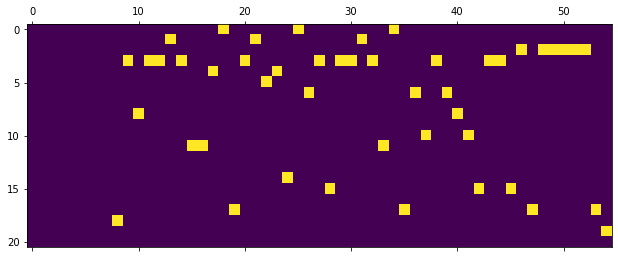

In [5]:
mol_vects = sm_en.transform(mols)
plt.matshow(mol_vects[0].T)

In [6]:
mol_vects.shape

(20, 55, 21)

In [7]:
#We make up some labels
y = range(len(mols))
smi_seq = SmilesSequence(mols, y, sm_en, batch_size=3)
print(len(smi_seq))

7


In [8]:
batch_x, batch_y = smi_seq[0]
print(batch_y)

[ 2 13  0]


In [9]:
y=[1,2]*10
#Set data augmentation on
sm_en.augment=True
sm_en.canonical=False

sm_gn = SmilesGenerator(mols, y, sm_en, batch_size=4, shuffle=True)

batch_x, batch_y = sm_gn.next()
print(batch_x.shape)
print(batch_y.shape)

(4, 55, 21)
(4,)


In [10]:
#If settings on generator is the same, it can be reused, otherwise recreate
import copy
vect1 = sm_en
vect2 = copy.deepcopy(sm_en)
vect2.augment = False # Set the augment to be false for testing purposes
vect2.leftpad = False # Set the order of the SMILES to be from left to right

print(vect1.augment)
print(vect2.augment) 

True
False


In [11]:
batchgen = HetSmilesGenerator(mols, None, vect1, vect2, batch_size=3) #Y is None
_input, _output = batchgen.next()

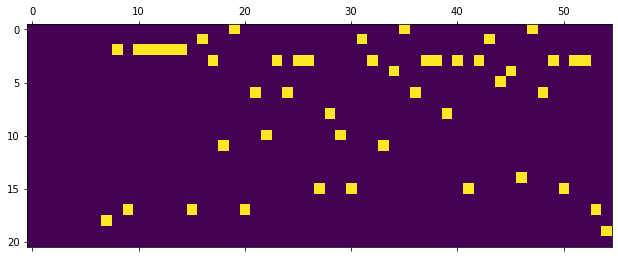

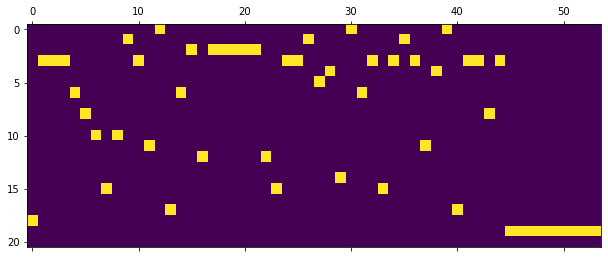

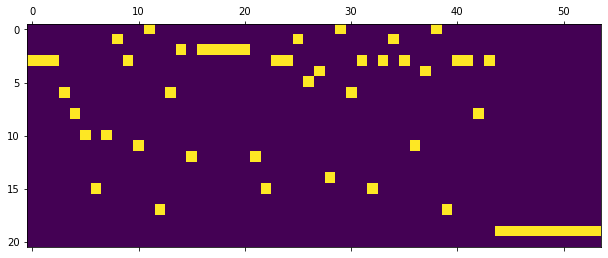

In [12]:
plt.matshow(_input[0][0].T)
plt.matshow(_input[1][0].T)
plt.matshow(_output[0].T)

In [13]:
zinc20_path = Path("/storage2/zinc20")

In [28]:
def read_smiles_file(smiles_file, delimiter=' ', smiles_column=0,
                     name_column=1, header=False, requires_length=False):
    """Read a SMILES file.

    Parameters
    ----------
    smiles_file: path to a SMILES file
    requires_length: If True returns an enumerated Mol
        supplier, i.e. when monitoring progress

    Returns
    -------
    either a MolSupplier or an EnumeratedSupplier
    depending on whether a length is required
    """

    if requires_length is False:
        return MolSupplier(
            SmilesMolSupplier(
                smiles_file,
                delimiter,
                smiles_column,
                name_column,
                header,
                True))

    count = smiles_count(smiles_file)
    if header is True:
        count -= 1

    supplier = SmilesMolSupplier(smiles_file, delimiter, smiles_column, name_column, header, True)

    return EnumeratedMolSupplier(supplier, count) 

In [17]:
def read_smiles(path):
    result = []
    suppl = Chem.SmilesMolSupplier(path)
    for mol in suppl: result.append(mol)
    return result 

In [36]:
zinc_file = "AA/AAAD.smi"
path = (zinc20_path/zinc_file).absolute().as_posix()
mols = read_smiles(path)

smiles = [Chem.MolToSmiles(mol) for mol in mols]
smiles_lens = [len(smi) for smi in smiles]
smiles_df = pd.DataFrame({"smiles": smiles, "lengths": smiles_lens})

<AxesSubplot:>

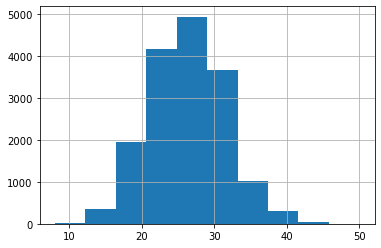

In [38]:
smiles_df["lengths"].hist()

In [24]:
sm_en = SmilesVectorizer(canonical=True, augment=False)

print("Default Charset %s"%sm_en.charset)
print("Default Maximum allowed SMILES length %s"%sm_en.maxlength)

sm_en.fit(mols, extra_chars=["\\"])
print()
print("After fitting")
print("Charset after fit %s"%sm_en.charset)
print("Length of charset %s"%len(sm_en.charset))
print("Maximum allowed SMILES length %s"%sm_en.maxlength)

Default Charset @C)(=cOn1S2/H[N]\^$?
Default Maximum allowed SMILES length 120

After fitting
Charset after fit ]sl[3c-BCHN(no=SO@#2P\F)+/1^$?
Length of charset 30
Maximum allowed SMILES length 50


In [25]:
vect1 = sm_en
vect2 = copy.deepcopy(sm_en)
vect2.augment = False # Set the augment to be false for testing purposes
vect2.leftpad = False # Set the order of the SMILES to be from left to right

print(vect1.augment)
print(vect2.augment) 

False
False


In [26]:
batchgen = HetSmilesGenerator(mols, None, vect1, vect2, batch_size=3) #Y is None
_input, _output = batchgen.next()

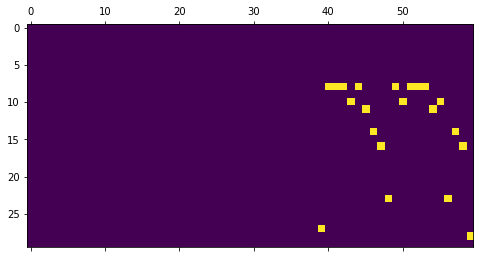

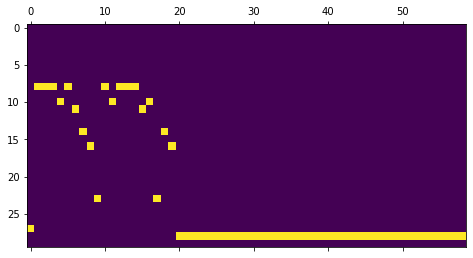

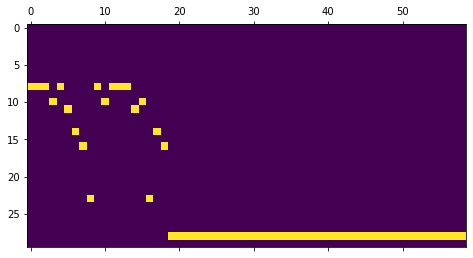

In [27]:
plt.matshow(_input[0][0].T)
plt.matshow(_input[1][0].T)
plt.matshow(_output[0].T)